# Imports

In [1]:
# Add the directory where starships' directory is located
from sys import path
path.append('/home/mathisb/Github/')

# Add the directory containing the input data (opacity, abundance and stellar specs files)
import os
os.environ['pRT_input_data_path'] = '/home/mathisb/projects/def-ncowan/input_data'

from pathlib import Path

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from importlib import reload
import starships.plotting_fcts as pf 

import astropy.units as u
import astropy.constants as const

from starships import homemade as hm
from itertools import product

from scipy.interpolate import interp1d

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
# %matplotlib notebook
%matplotlib inline

# Setting plot parameters
couleurs = hm.get_colors('magma', 50)[5:-2]

# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler(color=hm.get_colors('magma', 50))
# ex : list_of_color = [(i,0,0) for i in np.arange(10)/10]

In [5]:
from starships.correlation_class import Correlations
import starships.correlation_class as cc
from starships import correlation as corr

cc=reload(cc)

import starships.planet_obs as pl_obs
from starships.planet_obs import Observations, Planet

pl_obs=reload(pl_obs)

# Read pre-generated model

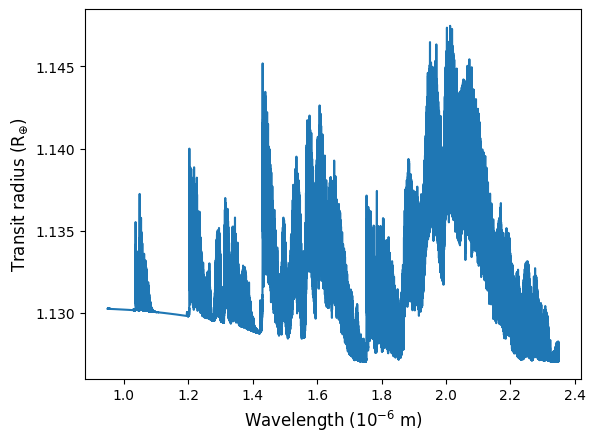

In [6]:
#-------------------------------------------------------------#
# Where to find the models
model_directory = "/home/mathisb/Github/HRS_models/"

# Name of npz model file
model_filename = "prt_model_TRAPPIST-1b_CO2_v02.npz"
#-------------------------------------------------------------#

model_file = np.load(model_directory + model_filename)
wave_mod, model_spec = model_file['wave_mod'], model_file['model_spec']

# Plot it
plt.plot(wave_mod, model_spec)

plt.xlabel('Wavelength ($10^{-6}$ m)', fontsize=12)
plt.ylabel(r'Transit radius ($\rm R_{\oplus}$)', fontsize=12)
plt.show()

# Get planet info and determine directories to use

In [32]:
#-----------------------------------------------------------#
# Planet parameters and reduction details
pl_name = 'TRAPPIST-1 b'

visit_name = '2019-09-25'
reduc_version = 'v001'
instrument = "SPIRou"

# Most parameters from trappist.one website
ap     = 0.01150*u.au       # semi-major axis of planet
R_star = 0.121*u.R_sun      # radius of star
R_pl   = 1.127*u.R_earth    # radius of planet
M_star = 0.089*const.M_sun  # mass of star
e      = 0                  # eccentricity
w      = 4.712389*u.rad     # argument of periapsis (equal to 270 degrees)

#-----------------------------------------------------------#

# Mid-transit time (BJD) of each TRAPPIST-1 b visit (calculated from Agol et al. 2021)
mid_tr_dict = {"2019-06-14": 2458649.07123219 * u.d,
               "2019-09-25": 2458751.81121859 * u.d,
               "2020-05-31": 2459001.10675595 * u.d,
               "2020-08-04": 2459066.07480784 * u.d,
               "2020-09-08": 2459100.82490157 * u.d,
               "2020-09-20": 2459112.91190288 * u.d,
               "2020-09-26": 2459118.95517189 * u.d,
               "2020-09-29": 2459121.97749932 * u.d,
               "2021-10-21": 2459508.7625026763 * u.d,
               "2021-10-24": 2459511.7847065893 * u.d,
               "2021-10-27": 2459514.8059848337 * u.d,
                }

mid_tr = mid_tr_dict[visit_name]

pl_kwargs = {'M_star': M_star, 
             'R_star': R_star,
             'ap': ap,
             'R_pl': R_pl,
             'mid_tr': mid_tr,
             'excent': e,
             'w': w}

planet_obj=Planet(pl_name, **pl_kwargs)

Getting TRAPPIST-1 b from ExoFile
Changing M_star from [1.5907279e+29] kg to 1.769684784921265e+29 kg
It became [1.76968478e+29] kg
Changing R_star from [0.] m to 0.121 solRad
It became [84179700.] m
Changing ap from [1.72546184e+09] m to 0.0115 AU
It became [1.72037551e+09] m
Changing R_pl from [6934724.] m to 1.127 earthRad
It became [7188118.7] m
Changing mid_tr from [2457322.514193] d to 2458751.81121859 d
It became [2458751.81121859] d
Changing excent from pl_orbeccen
-----------
    0.00622 to 0
It became 0
Changing w from [10.5917051] rad to 4.712389 rad
It became [4.712389] rad


In [33]:
#-----------------------------------------------------------#
# Where to find the reductions
reduc_in_scratch = True  # the reductions are in the scratch directory (True) or in the home directory (False)

# Indicate which reductions to use (sequence files)
filename_list = [
                 f"sequence_1-pc_mask_wings97_data_trs_{visit_name}.npz",
               #  f"sequence_2-pc_mask_wings97_data_trs_{visit_name}.npz",
                 # f"sequence_3-pc_mask_wings97_data_trs_{visit_name}.npz",
                 # f"sequence_4-pc_mask_wings97_data_trs_{visit_name}.npz",
                 # f"sequence_5-pc_mask_wings97_data_trs_{visit_name}.npz",
                 # f"sequence_6-pc_mask_wings97_data_trs_{visit_name}.npz",
                 # f"sequence_7-pc_mask_wings97_data_trs_{visit_name}.npz",
                ]
#-----------------------------------------------------------#

# Directory where the reductions are
if reduc_in_scratch:
    base_dir = Path(os.environ['SCRATCH'])
else:
    base_dir = Path.home()

pl_name_fname = ''.join(pl_name.split())

reduc_dir = base_dir / Path(f'HRS_reductions/{instrument}/{pl_name_fname}/{visit_name}/{reduc_version}')

print("Reduction directory is:", reduc_dir)

Reduction directory is: /scratch/mathisb/HRS_reductions/SPIRou/TRAPPIST-1b/2019-09-25/v001


In [34]:
#-----------------------------------------------#
# Where to output the correlations
output_dir = base_dir / Path(f'HRS_correlations/{instrument}/{pl_name_fname}/{visit_name}')
#-----------------------------------------------#

# Create output directory if it does not exist
output_dir.parent.mkdir(parents=True, exist_ok=True)

print("Correlations directory is:", output_dir)

Correlations directory is: /scratch/mathisb/HRS_correlations/SPIRou/TRAPPIST-1b/2019-09-25


# Correlations

In [35]:
#----------------------------------------------------------#
# Cross-correlation axes
step_RV_inj = 2.14  # 2 times the resolution of SPIRou in km/s
corrRV0 = np.arange(-150, 150, step_RV_inj)  # x axis (Vsys)

kind_trans = 'transmission'  # emission or transmission
#----------------------------------------------------------#

# GENERATE KP/VSYS MAP
model_name = model_filename[10:][:-4]

n_pc_list = []
mask_wings_list = []
all_obs = dict()
all_ccf_map = dict()
all_logl_map = dict()

for filename in filename_list:
    obs = pl_obs.load_single_sequences(filename, pl_name, path=reduc_dir,
                              load_all=False, filename_end='', plot=False, planet=planet_obj)
    
    # Generate Kp 
    Kp_array = np.array([obs.Kp.value]) 
        
    n_pc = int(obs.params[5])
    n_pc_list.append(n_pc)
    
    mask_wings = int(obs.params[1] * 100)  # in percent
    mask_wings_list.append(mask_wings)
    
    out_filename = f'{Path(filename).stem}_ccf_logl_seq_{model_name}'
    
    try:
        # Check if already generated
        saved_values = np.load(output_dir / Path(out_filename).with_suffix('.npz'))
        ccf_map = saved_values['corr']
        logl_map = saved_values['logl']
    except FileNotFoundError:
        # Generate 1d correlations
        # ccf_map shape: (n_exposures, n_order, n_Kp, n_vsys, n_pc, n_model) 
        ccf_map, logl_map = corr.calc_logl_injred(obs,
                            'seq', planet_obj, Kp_array, corrRV0, [n_pc], wave_mod, model_spec, kind_trans)
    
        corr.save_logl_seq(output_dir / Path(out_filename), ccf_map, logl_map,
                           wave_mod, model_spec, n_pc, Kp_array, corrRV0, kind_trans)
    
    all_obs[(n_pc, mask_wings)] = obs
    all_ccf_map[(n_pc, mask_wings)] = ccf_map
    all_logl_map[(n_pc, mask_wings)] = logl_map


[2458751.81121859] d
Transmission


## Plots

Max value at 1 npc = 0.5817889173180785 at -2.958804158594041 km/s
Max value at 1 npc = 0.44956906965250915 at -3.0183368252690466 km/s
Max value at 1 npc = 0.44956906965250915 at -3.0183368252690466 km/s
CCF SNR peak at Vrad*: [0.58178892]
log(L) abs peak at Vrad*: [268152.36193347]
log_10(ΔBIC) peak at Vrad*: [63.37476088]
[0.]
(14, 141)
(array([54, 55, 56]),)
In-transit t-val = 0.49 / p-val 6.32e-01 / sig = -0.34
Out-of-transit t-val = 1.22 / p-val 2.31e-01 / sig = 0.74


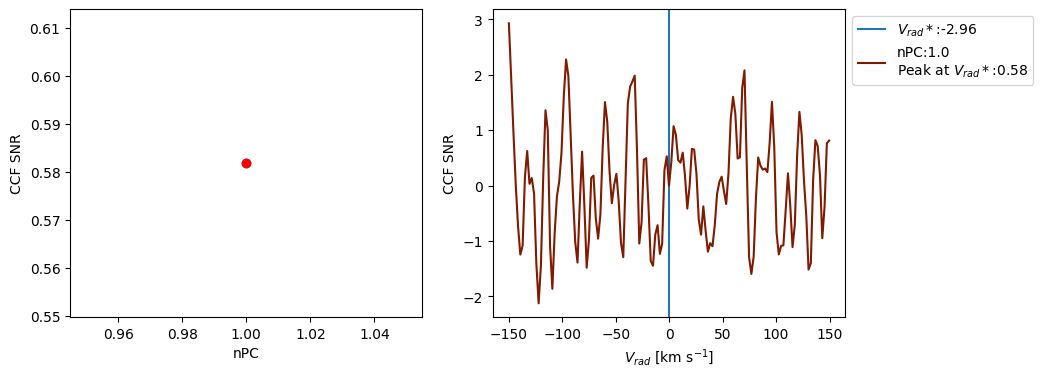

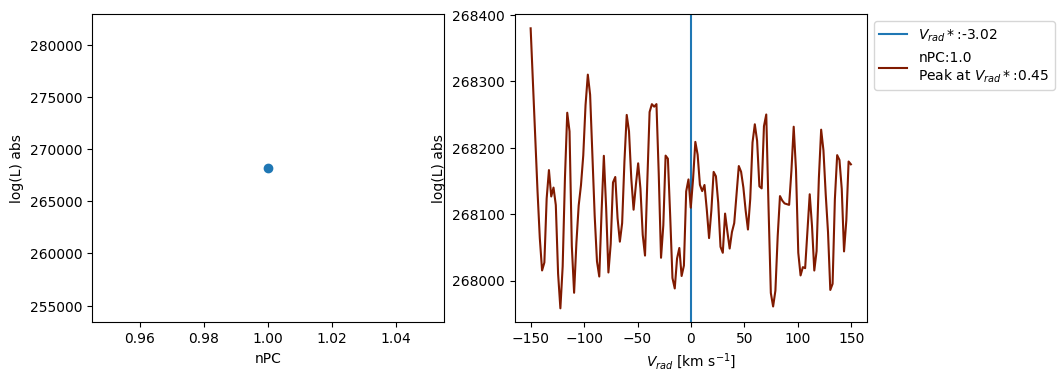

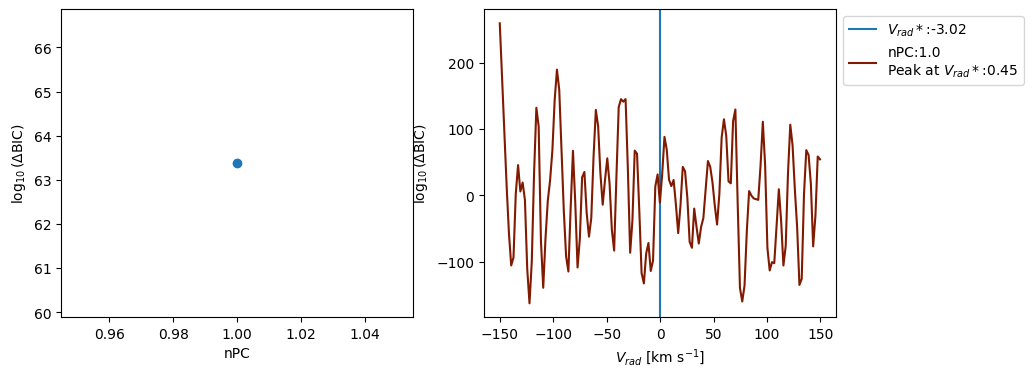

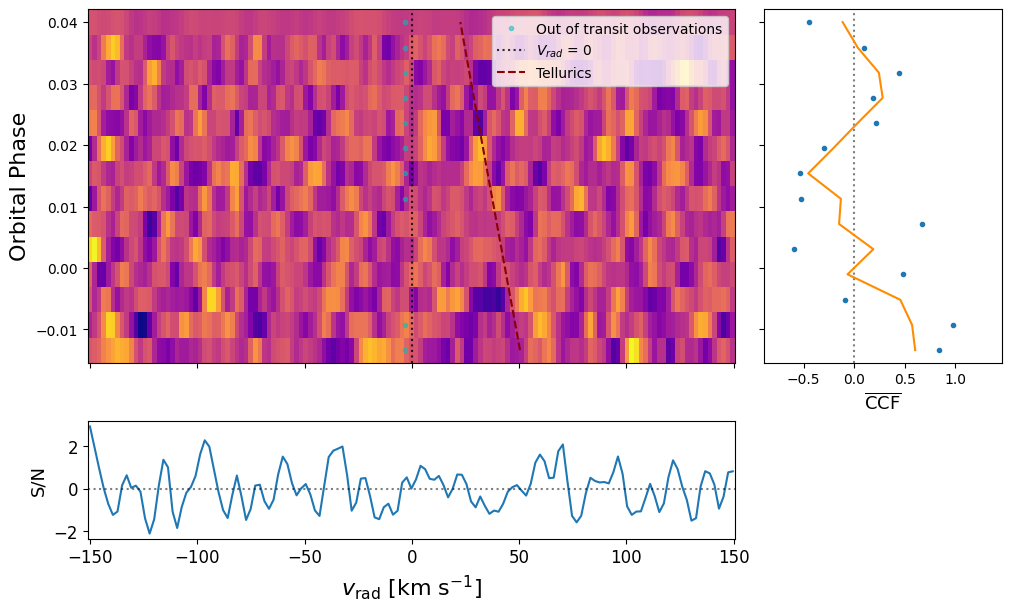

In [53]:
#----------------------------------------------#
# Indicate orders to use
nb_orders = 49  # number of orders in reduction
orders_to_delete = [[0,1,2,3,4,5,8,9], [11,12,13,14,15,22], [23,24,25,26,26,35,36],
                    [37,38,39,45], [46,47,48]]  # indices of orders that should not be used


# 2019-06-14: delete [0,1,2,3,4], [11,12,13], [23,24,25], [37,38,39], [46,47,48]
# 2019-09-25: delete [0,1,2,3,4], [11,12,13,14], [23,24,25], [37,38,39], [46,47,48]
# 2020-05-31: delete [0,1,2,3,4], [11,12,13], [23,24,25], [37,38,39], [46,47,48]
# 2020-08-04: delete [0,1,2,3,4], [11,12,13], [23,24,25], [37,38,39], [46,47,48]
# 2020-09-08: delete [1,2,3,4], [11,12,13], [23,24,25], [37,38,39], [46,47,48]
# 2020-09-20: delete [0,1,2,3,4], [11,12,13,14], [23,24,25], [37,38,39], [46,47,48]  # 14 is not sooo bad
# 2020-09-26: delete [0,1,2,3,4], [11,12,13], [23,24,25], [37,38,39], [46,47,48]
# 2020-09-29: delete [0,1,2,3,4], [11,12,13], [23,24,25], [37,38,39], [46,47,48]
# 2021-10-21: delete [0,1,2,3,4], [11,12,13], [23,24,25], [37,38,39], [46,47,48]
# 2021-10-24: delete [1,2,3,4], [11,12,13], [23,24,25], [37,38,39], [46,47,48]
# 2021-10-27: delete [1,2,3,4], [11,12,13], [23,24,25], [37,38,39], [46,47,48]

#----------------------------------------------#

order_indices = np.arange(nb_orders)

# Remove each element of orders_to_delete from array of orders
for elem in orders_to_delete:
    order_indices = np.setdiff1d(order_indices, elem)

n_pc_list = np.unique(n_pc_list)
mask_wings_list = np.unique(mask_wings_list)

id_pc0 = 0  # don't change

# Plot all ccf and logl as a function of pc
for mask_wings in mask_wings_list:
    ccf_maps_in = [all_ccf_map[(n_pc, mask_wings)] for n_pc in n_pc_list]
    ccf_maps_in = np.concatenate(ccf_maps_in, axis=-2)
    logl_maps_in = [all_logl_map[(n_pc, mask_wings)] for n_pc in n_pc_list]
    logl_maps_in = np.concatenate(logl_maps_in, axis=-2)
    obs = all_obs[(n_pc_list[0], mask_wings)]

    ccf_obj, logl_obj = cc.plot_ccflogl(obs, ccf_maps_in, logl_maps_in, corrRV0,
                                        Kp_array, n_pc_list, orders=order_indices, id_pc0=id_pc0)

# # Print info about the plots
# print("\nInformation about the plots:\n" + cc.plot_ccflogl.__doc__ + "\n" + 
#       Correlations.plot_multi_npca.__doc__ + "\n" + Correlations.plot_PRF.__doc__)


### Define n_pc and mask_wings used in the next few plots

In [54]:
n_pc, mask_wings = 1, 97

#----------------------------

filename = f'sequence_{n_pc}-pc_mask_wings{mask_wings}_data_trs_{visit_name}.npz'

[2458751.81121859] d
Transmission
Max value at 1 npc = 0.5817889173180785 at -2.958804158594041 km/s
Max value at 1 npc = 0.44956906965250915 at -3.0183368252690466 km/s
Max value at 1 npc = 0.44956906965250915 at -3.0183368252690466 km/s
CCF SNR peak at Vrad*: [0.58178892]
log(L) abs peak at Vrad*: [268152.36193347]
log_10(ΔBIC) peak at Vrad*: [63.37476088]
[0.]
(14, 141)
(array([54, 55, 56]),)
In-transit t-val = 0.49 / p-val 6.32e-01 / sig = -0.34
Out-of-transit t-val = 1.22 / p-val 2.31e-01 / sig = 0.74


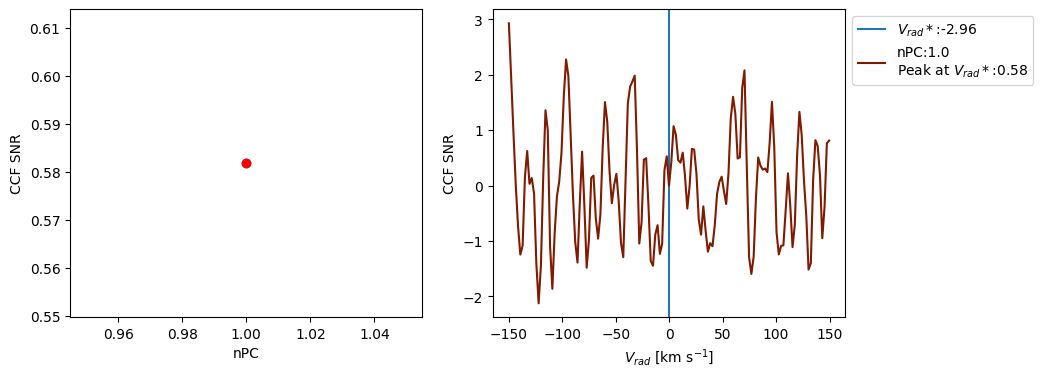

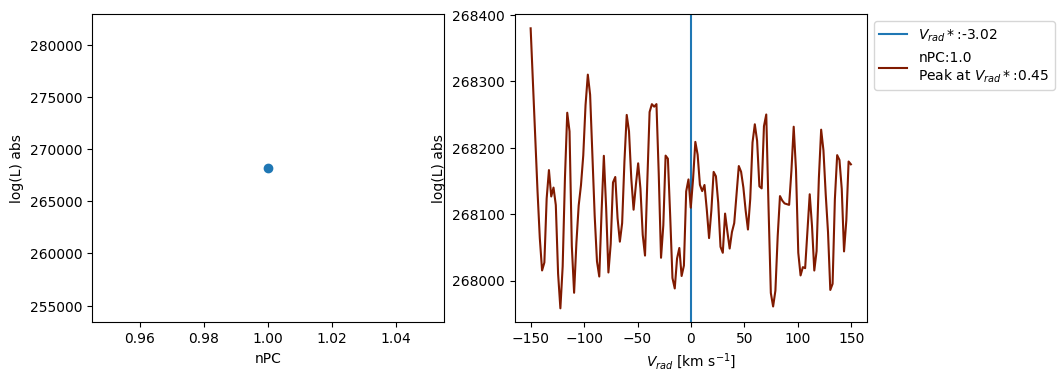

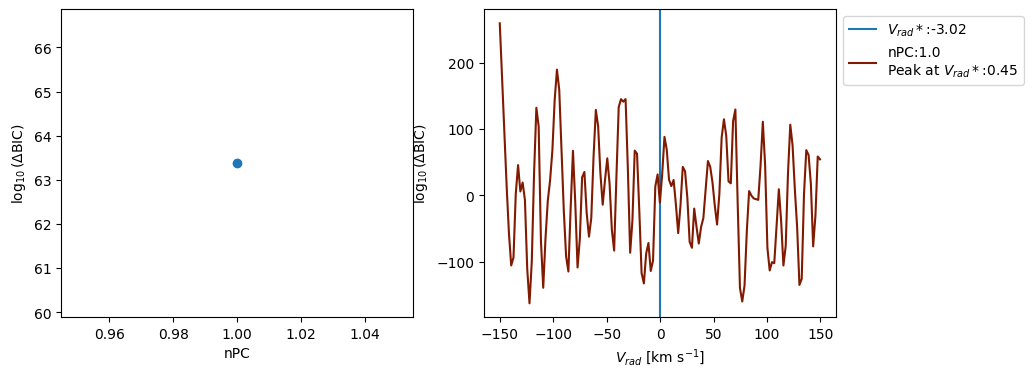

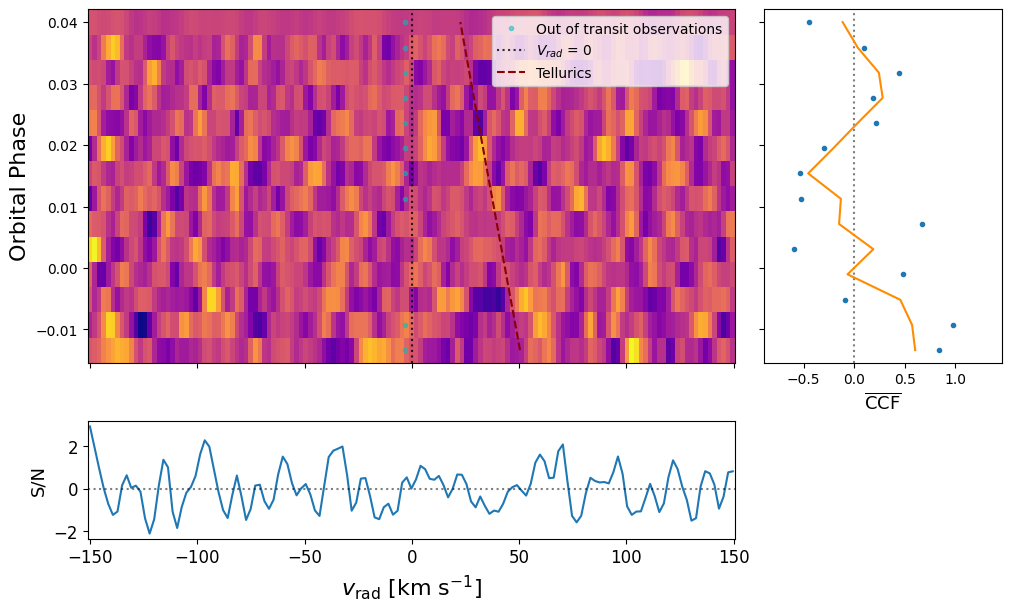

In [55]:
# Plot single ccf and logl

obs = pl_obs.load_single_sequences(filename, pl_name, path=reduc_dir,
                              load_all=False, filename_end='', plot=False, planet=planet_obj)

args = [all_something[(n_pc, mask_wings)]
        for all_something in [all_obs, all_ccf_map, all_logl_map]]
ccf_obj, logl_obj = cc.plot_ccflogl(*args, corrRV0, Kp_array, [n_pc], orders=order_indices)

T-val : Max value = 0.9 // Max position = 3.0
Histogram for Kp = 82.83 and RV = -2.96
0.4799284160267341 0.6396946798033813 -0.3576428051314687


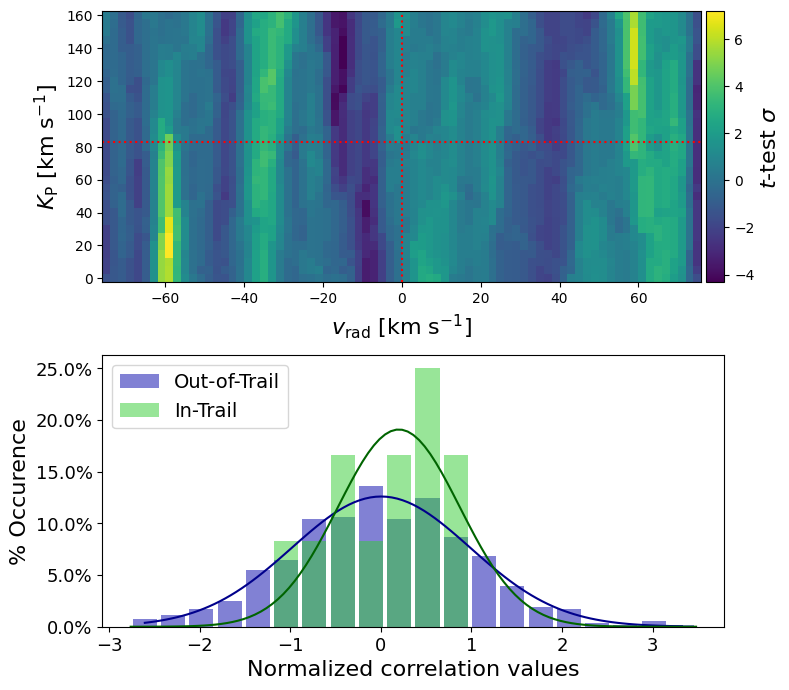

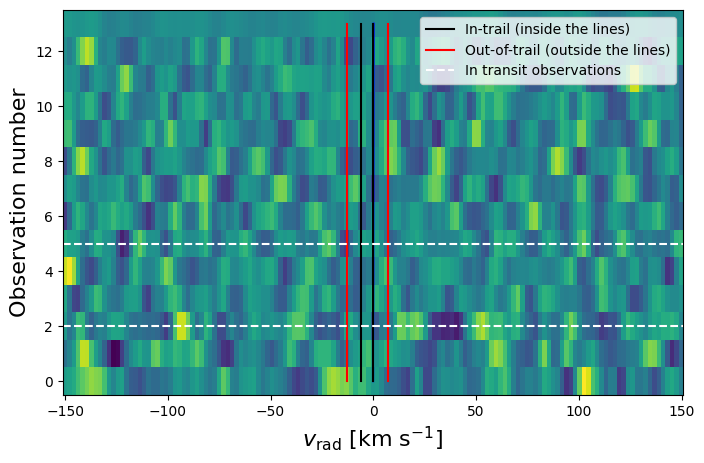

<Figure size 640x480 with 0 Axes>

In [56]:
# Generate the ttest map

ccf_obj.ttest_map(all_obs[(n_pc, mask_wings)], kind='logl', vrp=np.zeros_like(obs.vrp), orders=order_indices, 
                  kp0=0, RV_limit=75, kp_step=5, rv_step=2, RV=None, speed_limit=3, icorr=obs.iIn, equal_var=False
                  )

# # Print info about the plots
# print("\nInformation about the plots:\n" + pf.plot_ttest_map_hist.__doc__)

T-val : Max value = 0.6 // Max position = 3.0
Histogram for Kp = 82.83 and RV = -2.96


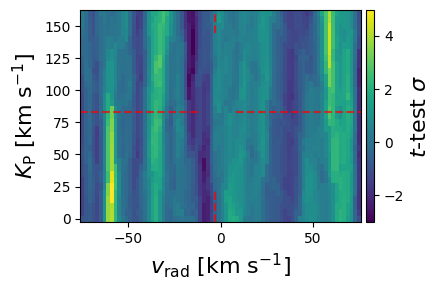

In [57]:
# Plot SCALED Kp/Vrad plot (good for science)

tr=all_obs[(n_pc, mask_wings)]
cobj = ccf_obj
t_value = cobj.ttest_map_tval

t_value_scaled = t_value*(-3)/t_value.min()

(t_in, p_in) = pf.plot_ttest_map_hist(tr, cobj.rv_grid, cobj.map_prf.copy(), 
                                           cobj.ttest_map_kp, cobj.ttest_map_rv, 
                                    t_value_scaled, cobj.ttest_map_params, 
                              plot_trail=True, masked=True, ccf=cobj.map_prf.copy(),
                              vrp=np.zeros_like(tr.vrp), RV=cobj.pos, hist=False,
                                      show_max=False, show_rest_frame=False,
                                    fig_name='', path_fig=None, orders=order_indices)
# fig.get_axes()[0].text(-67.0, 300, r'H$_2$O', fontsize=16, bbox ={'facecolor':'white', 'alpha':0.8})
fig = plt.gcf()
ax = fig.axes

pos_max = -3.2
# - Lines enclosing the maximum -
ax[0].axhline(tr.Kp.to(u.km / u.s).value, linestyle='--', alpha=0.7, color='r', 
              xmin=0,xmax=hm.nearest(cobj.interp_grid, pos_max-20)/cobj.interp_grid.size )
ax[0].axhline(tr.Kp.to(u.km / u.s).value, linestyle='--', alpha=0.7, color='r',
              xmin=hm.nearest(cobj.interp_grid, pos_max+20)/cobj.interp_grid.size ,xmax=1) 
ax[0].axvline(pos_max, linestyle='--', alpha=0.7, color='r', 
                  ymin=0, ymax=(tr.Kp.value - 60)/cobj.ttest_map_kp[-1] )
ax[0].axvline(pos_max, linestyle='--', alpha=0.7, color='r',
                  ymin=(tr.Kp.value + 60)/cobj.ttest_map_kp[-1] , ymax=1)
fig.set_size_inches(4.5,3)
plt.tight_layout()
#fig.savefig(data_path+'Figures/'+'t3_H2O_night.pdf', rasterize=True)

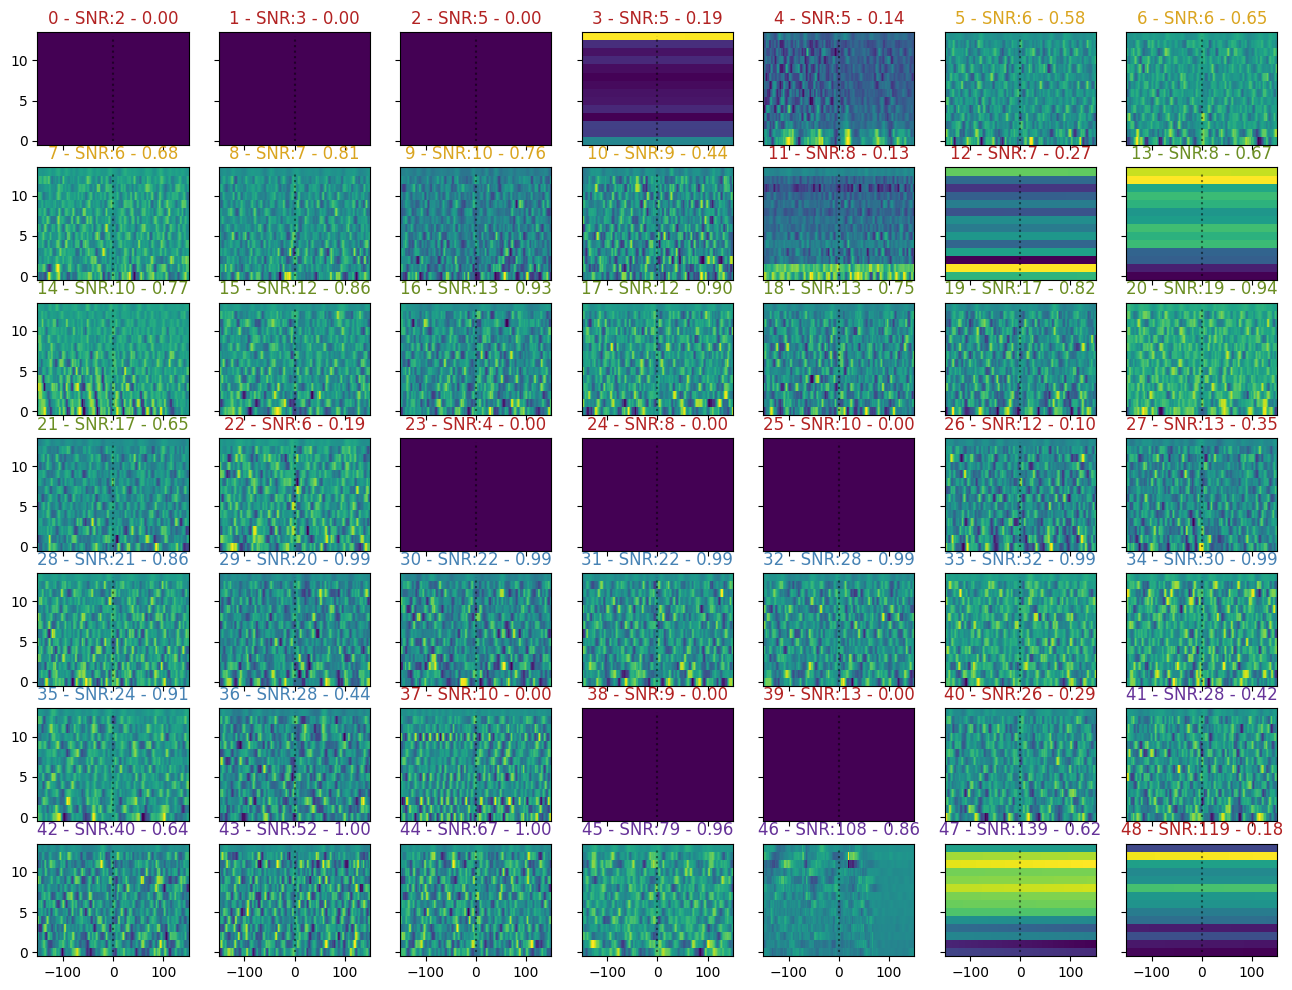

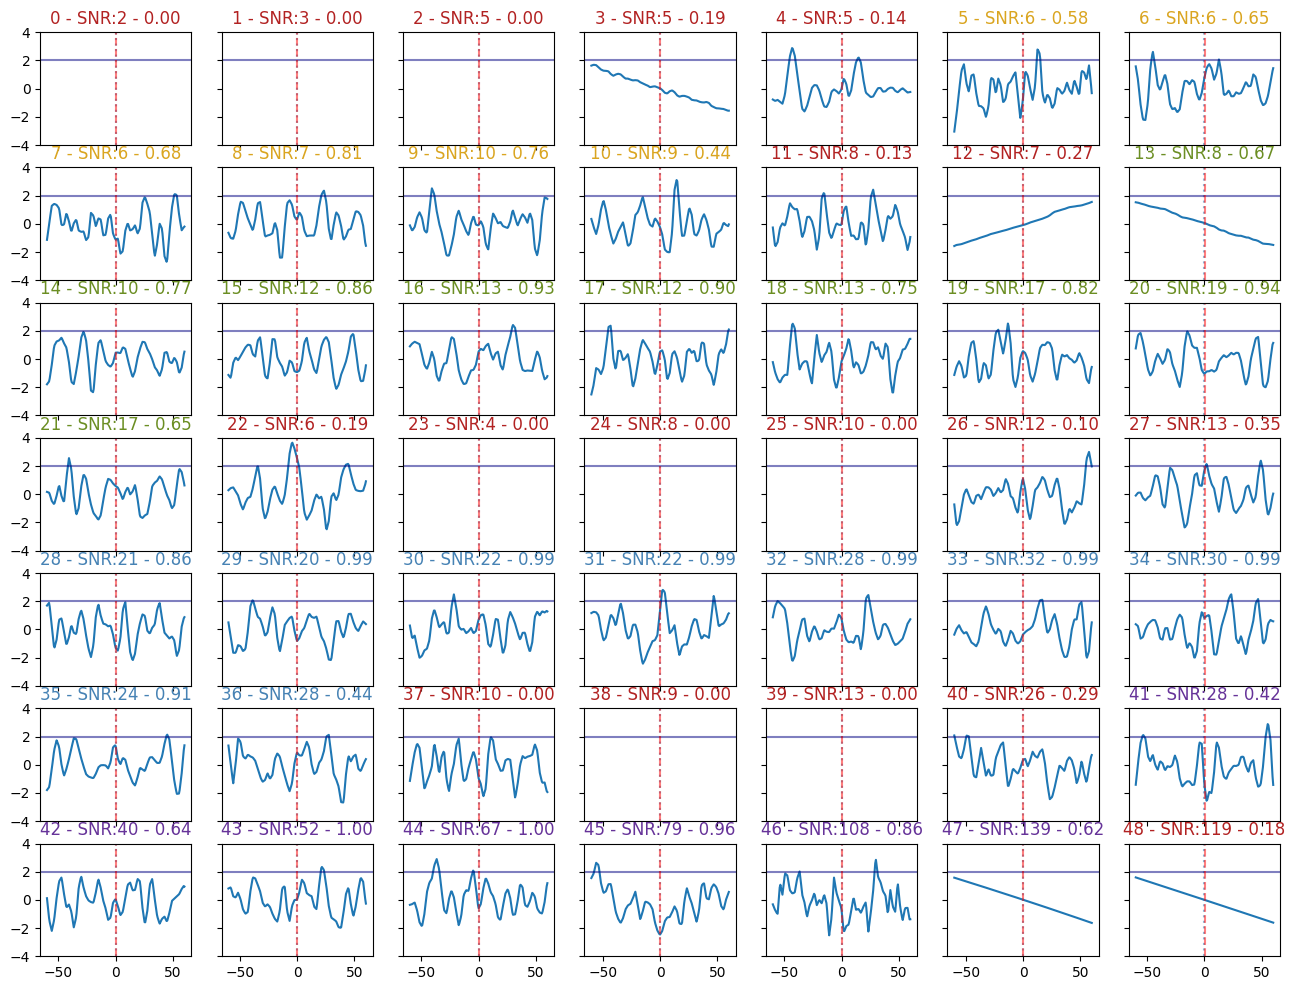

In [41]:
# Plot all orders

pf.plot_all_orders_correl(corrRV0,ccf_obj.data.squeeze(), all_obs[(n_pc, mask_wings)],
                                      icorr=None, logl=False, sharey=True,
                                      vrp=np.zeros_like(all_obs[(n_pc, mask_wings)].vrp),
                              RV_sys=0.0, vmin=None, vmax=None,
                                      vline=None, hline=2, kind='snr', return_snr=False)

In [58]:
# PLOT THE MODEL ORDER BY ORDER

# Orders to plot
order_plot = []

#---------------------------------------------------------------


fct_model = interp1d(wave_mod, model_spec, kind='cubic')

for i_ord in order_plot:

    wv_ord = all_obs[(n_pc, mask_wings)].wv[i_ord]
    mask_ord = all_obs[(n_pc, mask_wings)].final.mask[0, i_ord]
    
    coeff = np.polyfit(wv_ord, fct_model(wv_ord), 1)
    model_ord = np.ma.array(fct_model(wv_ord), mask=mask_ord)
    
    plt.figure()
    poly_fct = np.poly1d(coeff)
    plt.plot(wv_ord, model_ord / poly_fct(wv_ord))
    plt.title("Order #" + str(i_ord))
    
    #plt.gca().twinx().plot(wv_ord, mask_ord, 'r')

# Combine visits

In [34]:
pl_obs = reload(pl_obs)

In [15]:

# To combine: visit name, reduction version, sequence file
file_arr = np.array([
                    ['2019-06-14', 'v001', 'sequence_1-pc_mask_wings97_data_trs_2019-06-14.npz'],
                    ['2019-09-25', 'v006', 'sequence_1-pc_mask_wings97_data_trs_2019-09-25.npz'],
                    ['2020-05-31', 'v001', 'sequence_1-pc_mask_wings97_data_trs_2020-05-31.npz'],
             #       ['2020-08-04', 'v001', 'sequence_1-pc_mask_wings97_data_trs_2020-08-04.npz'],
                    ])

kind_trans = 'transmission'  # emission or transmission
ld_model = 'nonlinear'
coeffs = [0.02703969,  1.10037972, -0.96372403,  0.28750393]  # limb darkening coefficients

# Cross-correlation axes
step_RV_inj = 2.14  # 2 times the resolution of SPIRou in km/s
#######################corrRV0 = np.arange(-150, 150, step_RV_inj)  # x axis (Vsys)

corrRV0 = np.linspace(-150,150,151)

#-----------------------------------------------------------------------------------------------------------


model_name = model_filename[10:][:-4]

combined_ccf = []
combined_logl = []
combined_obs = []
visit_dict = dict()

for reduc_idx, reduc in enumerate(file_arr):
    
    visit = reduc[0]
    fname = reduc[2]
    
    # Where to find the reductions
    reduc_dir = base_dir / Path(f'HRS_reductions/{instrument}/{pl_name_fname}/{visit}/{reduc[1]}')
    
    # Where to find the correlations
    corr_dir = base_dir / Path(f'HRS_correlations/{instrument}/{pl_name_fname}/{visit}')
    
    # Redefine planet (since mid-tr time changes for each visit)
    mid_tr = mid_tr_dict[visit]

    pl_kwargs = {'M_star': M_star, 
                 'R_star': R_star,
                 'ap': ap,
                 'R_pl': R_pl,
                 'mid_tr': mid_tr,
                 'excent': e,
                 'w': w}

    planet_obj=Planet(pl_name, **pl_kwargs)
    
    print("")
    
    obs = pl_obs.load_single_sequences(fname, pl_name, path=reduc_dir,
                              load_all=False, filename_end='', plot=False, planet=planet_obj)
    
    print("")
    
    out_filename = f'{Path(fname).stem}_ccf_logl_seq_{model_name}'
    
    try:
        # Check if already generated
        saved_values = np.load(corr_dir / Path(out_filename).with_suffix('.npz'))
        ccf_map = saved_values['corr']
        logl_map = saved_values['logl']
    except FileNotFoundError:
        # Generate 1d correlations
        # ccf_map shape: (n_exposures, n_order, n_Kp, n_vsys, n_pc, n_model) 
        ccf_map, logl_map = corr.calc_logl_injred(obs,'seq', planet_obj, Kp_array,
                                                  corrRV0, [n_pc], wave_mod, model_spec, kind_trans)
    
    
        corr.save_logl_seq(corr_dir / Path(out_filename), ccf_map, logl_map,
                           wave_mod, model_spec, n_pc, Kp_array, corrRV0, kind_trans)

    visit_dict[str(reduc_idx + 1)] = obs
    combined_obs.append(obs)
    combined_ccf.append(ccf_map)
    combined_logl.append(logl_map)


transit_tags = [np.arange(obs.n_spec) for obs in visit_dict.values()]
all_visits = pl_obs.gen_merge_obs_sequence(obs, visit_dict, np.arange(1, len(file_arr) + 1), None, 
                                    coeffs, ld_model, kind_trans, light=True)

all_visits.dt = np.concatenate([vst.dt for vst in visit_dict.values()])  # exposition times

Getting TRAPPIST-1 b from ExoFile
Changing M_star from [1.5907279e+29] kg to 1.769684784921265e+29 kg
It became [1.76968478e+29] kg
Changing R_star from [0.] m to 0.121 solRad
It became [84179700.] m
Changing ap from [1.72546184e+09] m to 0.0115 AU
It became [1.72037551e+09] m
Changing R_pl from [6934724.] m to 1.127 earthRad
It became [7188118.7] m
Changing mid_tr from [2457322.514193] d to 2458649.07123219 d
It became [2458649.07123219] d
Changing excent from pl_orbeccen
-----------
    0.00622 to 0
It became 0
Changing w from [10.5917051] rad to 4.712389 rad
It became [4.712389] rad

[2458649.07123219] d
Transmission

Getting TRAPPIST-1 b from ExoFile
Changing M_star from [1.5907279e+29] kg to 1.769684784921265e+29 kg
It became [1.76968478e+29] kg
Changing R_star from [0.] m to 0.121 solRad
It became [84179700.] m
Changing ap from [1.72546184e+09] m to 0.0115 AU
It became [1.72037551e+09] m
Changing R_pl from [6934724.] m to 1.127 earthRad
It became [7188118.7] m
Changing mid_tr fro

In [38]:
cc=reload(cc)
### BELOW


Max value at 1 npc = 1.9763707364768537 at 0.4202935776922029 km/s
Max value at 1 npc = 1.7520696454567575 at 0.41313834806477046 km/s
Max value at 1 npc = 1.7520696454567575 at 0.41313834806477046 km/s
CCF SNR peak at Vrad*: [1.97637074]
log(L) abs peak at Vrad*: [-1850691.50392879]
log_10(ΔBIC) peak at Vrad*: [1.20532208]
[0.]
(42, 151)
(array([56, 57, 58]),)
In-transit t-val = 2.96 / p-val 5.36e-03 / sig = 2.55
Out-of-transit t-val = -0.43 / p-val 6.70e-01 / sig = -0.44
T-val : Max value = 3.7 // Max position = 1.3
Histogram for Kp = 82.83 and RV = 0.42
2.814294440587909 0.007813962004412454 2.4174909173818615
T-val : Max value = 3.4 // Max position = 1.3
Histogram for Kp = 82.83 and RV = 0.42


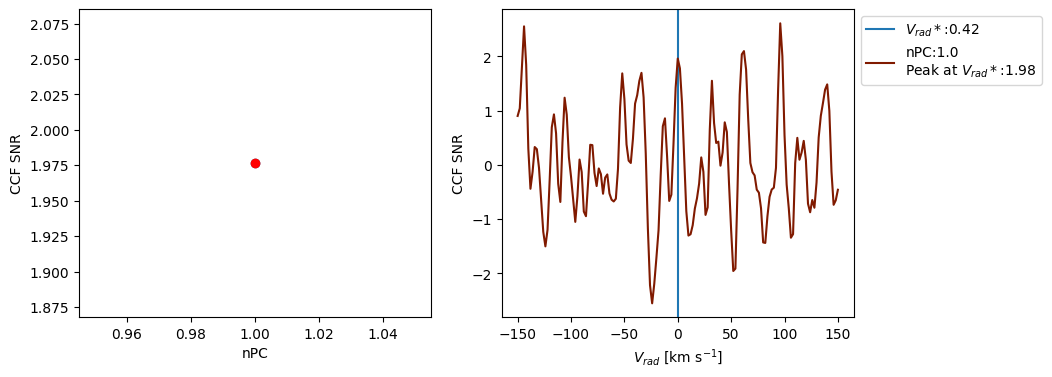

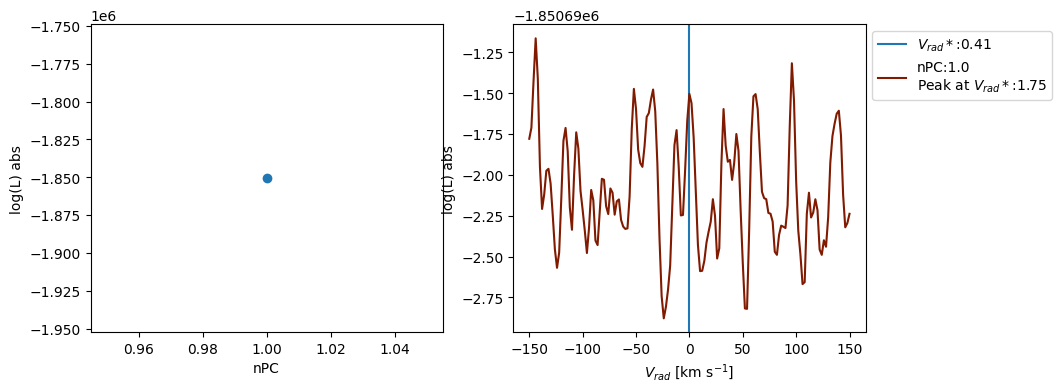

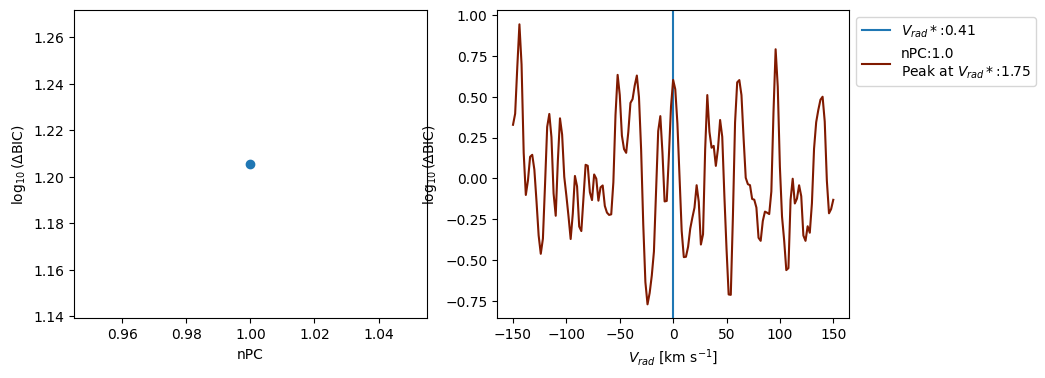

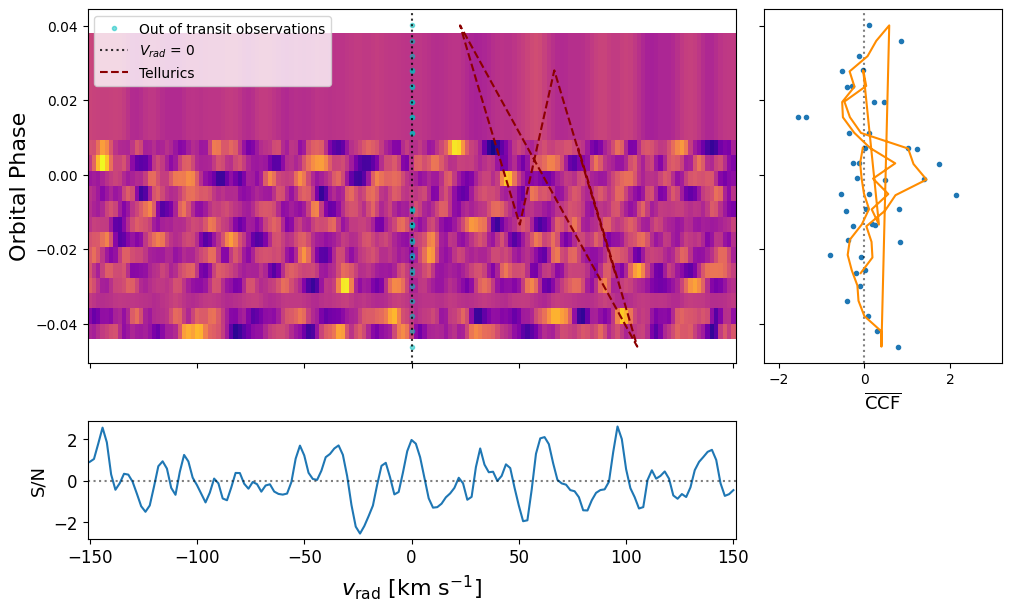

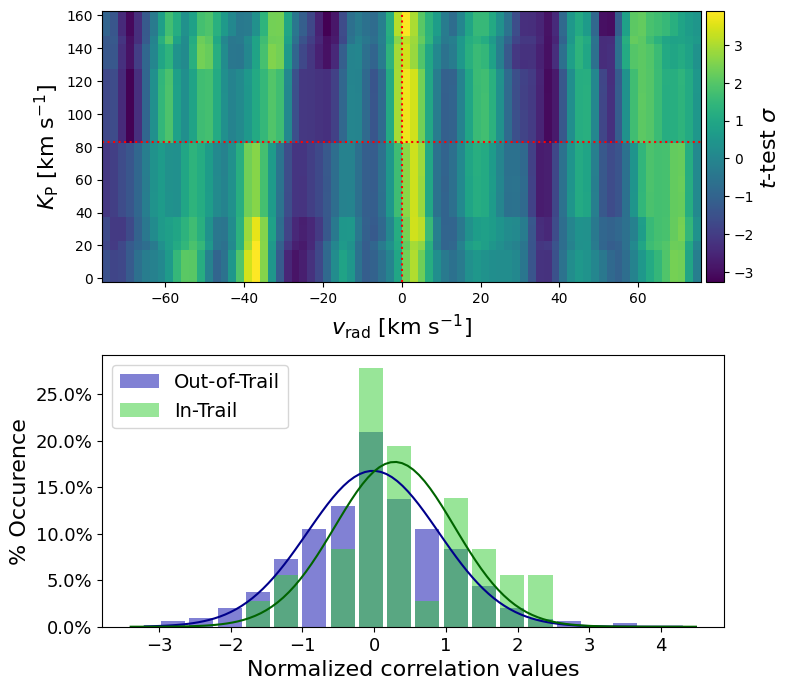

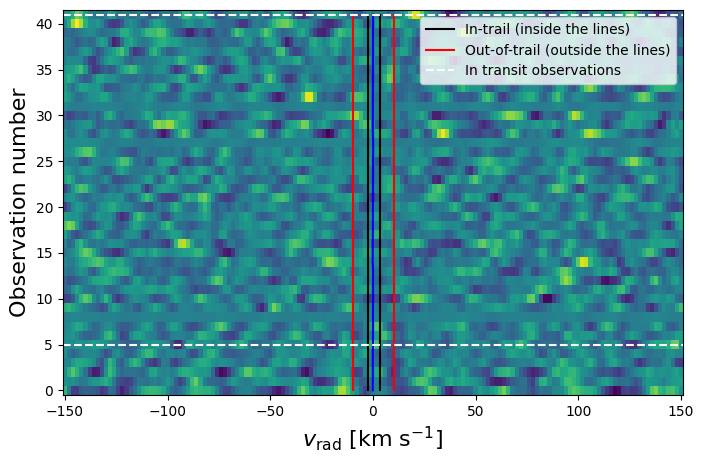

<Figure size 640x480 with 0 Axes>

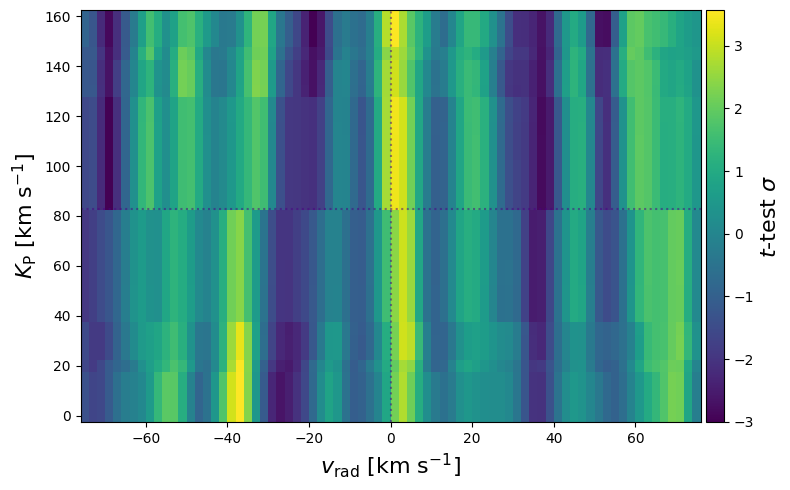

In [16]:
## NEED to make this more general, right now only works for 2 nights (I think)


# Indicate orders to use
nb_orders = 49  # number of orders in reduction
orders_to_delete = [[0,1,2,3,4], [11,12,13], [23,24,25],
                    [37,38,39], [46,47,48]]  # indices of orders that should not be used

#-------------------------------------------------------

idx_orders = np.arange(nb_orders)

# Remove each element of orders_to_delete from array of orders
for elem in orders_to_delete:
    idx_orders = np.setdiff1d(idx_orders, elem)

    
# Generate Kp 
Kp_array = np.array([obs.Kp.value]) 

ccf_map = np.concatenate(combined_ccf)
logl_map = np.concatenate(combined_logl)


ccf_obj, logl_obj = cc.plot_ccflogl(all_visits, 
                                    ccf_map,
                                    logl_map,
                                    corrRV0, Kp_array, [1],
                                  # split_fig = [0,t1.n_spec,t1.n_spec+t2.n_spec],  # don't use if only doing combined correlation
                                    orders=idx_orders
                                   )


ccf_obj.ttest_map(all_visits, kind='logl', vrp=np.zeros_like(all_visits.vrp), orders=idx_orders, 
                  kp0=0, RV_limit=75, kp_step=5, rv_step=2, RV=None, speed_limit=3, icorr=all_visits.iIn, equal_var=False, 
                  )



t_value = ccf_obj.ttest_map_tval

(t_in, p_in), fig = pf.plot_ttest_map_hist(all_visits, ccf_obj.rv_grid, ccf_obj.map_prf.copy(), 
                                           ccf_obj.ttest_map_kp, ccf_obj.ttest_map_rv, 
                                    t_value*(-3)/t_value.min(), ccf_obj.ttest_map_params, 
                              plot_trail=True, masked=True, ccf=ccf_obj.map_prf.copy(),
                              vrp=np.zeros_like(all_visits.vrp), RV=ccf_obj.pos, hist=False,
                                    fig_name='', path_fig=None, cmap='viridis')



In [ ]:
###############
############### BELOW HERE, code is not generalized to more than 2 observations ######################

In [14]:

visit_dict['12'] = all_visits

In [15]:




# Where to output the combined correlations
output_dir_comb = base_dir / Path(f'HRS_correlations/{instrument}/{pl_name_fname}/Combined/')

# Create output directory if it does not exist
output_dir_comb.parent.mkdir(parents=True, exist_ok=True)

print("Combined correlations directory is:", output_dir_comb)



filename_dict = {"1": 'sequence_1-pc_mask_wings97_data_trs_2019-09-25.npz',
             "2": 'sequence_1-pc_mask_wings97_data_trs_2020-05-31.npz'}


args_filename = [(key, str(visit_dict[key].params[5]), str(int(visit_dict[key].params[1] * 100)))
                 for key in filename_dict.keys()]
args_filename = ['-'.join(values) for values in zip(*args_filename)]
filename = 'combined_corr_nights{}_pc{}_mask_wings{}_'.format(*args_filename) + f"{model_name}"

print(filename)



###





Combined correlations directory is: /scratch/mathisb/HRS_correlations/SPIRou/TRAPPIST-1b/Combined
combined_corr_nights1-2_pc1-1_mask_wings97-97_TRAPPIST-1b_CO2_v02


In [16]:
# Save
# The [12] is the combined 1-2 nights, the key in visit_dict
pl_obs.save_sequences(filename, visit_dict, [12], path=output_dir_comb)

/scratch/mathisb/HRS_correlations/SPIRou/TRAPPIST-1b/Combined/combined_corr_nights1-2_pc1-1_mask_wings97-97_TRAPPIST-1b_CO2_v02_data_info.npz
